In [70]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Layer Norm by hand
- Fill in the Layer Norm application below. Make sure the manual and PyTorch implementations are the same.
- As before, FILL_IN the missing code to make this work.

In [71]:
FILL_IN = "FILL_IN"

In [72]:
# This is (N, T, d_model)
# N: batch size
# T: sentence_length
# d_model: embedding dimension

N, T, d_model = 2, 3, 4

# An embedding. This is what you might feed into a network.
embedding = torch.randn(N, T, d_model)

# Create a Layer Norm layer on the embedding dimension.
# Do not include gamma and beta, the learnable scaling and offset parameters.
# This should act of the dimenson of the model.
layer_norm = nn.LayerNorm(d_model)
# Run embedding through the layer_norm layer.
layer_norm_pytorch = layer_norm(embedding)

# Manual computation; use the same EPSILON as is used in the standard nn.LayerNorm.
EPSILON = 1e-5

# Grab the mean of each vector in the first batch. This should be (3, 1).
mean = torch.mean(embedding[0],dim=1).unsqueeze(1)
# Grab the var of each vector in the first batch. This should be (3, 1).
var = torch.var(embedding[0],dim=1, unbiased=False).unsqueeze(1)
# Manually take each vector in the batch and standerdize it.
layer_norm_manual = (embedding[0]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 0: ", layer_norm_manual)
print("layer_norm_out[0]: ", layer_norm_pytorch[0])
assert torch.allclose(layer_norm_pytorch[0], layer_norm_manual), 'Tensors do not match.'

mean = torch.mean(embedding[1],dim=1).unsqueeze(1)
var = torch.var(embedding[1],dim=1, unbiased=False).unsqueeze(1)
layer_norm_manual = (embedding[1]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 1: ", layer_norm_manual)
print("layer_norm_out[1]: ", layer_norm_pytorch[1])
assert torch.allclose(layer_norm_pytorch[1], layer_norm_manual), 'Tensors do not match.'

layer_norm_manual @ 0:  tensor([[ 1.0778,  0.8917, -0.7573, -1.2122],
        [ 0.6493, -1.1193, -0.8174,  1.2874],
        [ 0.8958, -1.4179, -0.4637,  0.9859]])
layer_norm_out[0]:  tensor([[ 1.0778,  0.8917, -0.7573, -1.2122],
        [ 0.6493, -1.1193, -0.8174,  1.2874],
        [ 0.8958, -1.4179, -0.4637,  0.9859]], grad_fn=<SelectBackward0>)
layer_norm_manual @ 1:  tensor([[ 0.1667, -0.8487, -0.8877,  1.5697],
        [-0.5175,  1.2202,  0.6476, -1.3504],
        [-1.6232, -0.0134,  0.9315,  0.7051]])
layer_norm_out[1]:  tensor([[ 0.1667, -0.8487, -0.8877,  1.5697],
        [-0.5175,  1.2202,  0.6476, -1.3504],
        [-1.6232, -0.0134,  0.9315,  0.7051]], grad_fn=<SelectBackward0>)


### Wave Net

In [73]:
# Hyperparameters we will use.                                                                                                                                                          
batch_size = 128 # How many independent sequences will we process in parallel?                                                                                              
context_size = 256 # What is the maximum context length for predictions? This is T below.                                                                                                    
epochs = 5000
eval_interval = 500
# Is this a good one? Can you check?
learning_rate = 3e-3
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
eval_iters = 200
d_model = 20
d_hidden = 100
n_layer = 1
dropout = 0.2
write_to_file = False
norm = 'batch_norm'

# Add more pritning to the model.
debug = False
# ------------        

In [74]:
torch.manual_seed(1337)

# Load the Shakespere document input.txt.                                                                          
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [75]:
# Get all the unique characters in the text.                                                                                                             
chars = list(set(text))
vocab_size = len(list(set(text)))
# As usual, create a mapping from a character to a text.                                                                                                                            
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x:[stoi[e] for e in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode = lambda x:''.join(itos[e] for e in x)

In [76]:
# Do a train-test split with 90% of the data train and 10% test.
# You can just use the first 90% of the data as training data.
# Run the text through the encode method.
data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n:]


In [77]:
# Load the data.
# This should return a small batch of data (x, y) where x is 
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y.
    # Pick the train data if split == 'train', else the validation data.
    data = train_data if split == 'train' else val_data
    # Select a random set of ints [0, len(data) - context_size) ; reshape this to be (batch_size, )
    # For an index i, a x should be data[i:i+context_size] while a y should be data[i+context_size].
    # ix has length batch_size.
    ix = torch.randint(0,len(data) - context_size, (batch_size, ))
    # Stack the batch_size data to be of shape (batch_size, context_size)
    x = torch.tensor([data[i.item():i.item()+context_size] for i in ix])
    # Stack the y targets; this should be of length batch_size.
    # You should pull out the i+context_size element of data; i is an index in ix.
    y = torch.tensor([data[i.item()+context_size] for i in ix])                                                                          
    x, y = x.to(device), y.to(device)
    return x, y

In [78]:
# Estimate the loss.

@torch.no_grad()
def estimate_loss():
    out = {}
    # Put the model in eval mode. Why?
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            # Get the value in the loss.
            losses[k] = loss.item()
        # Get the mean of the values in the losses.
        out[split] = losses.mean().item()
    # Put the model in train mode.
    model.train()
    return out

In [79]:
class WaveNetMLPLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        
        self.linear_layers = []
        self.norm_layers = []
        self.linear_layers_res = []

        temp_context_size = context_size
        
        while temp_context_size >= 10:
            # Map from 2 * d_model to d_hidden.
            if not self.linear_layers:
                # Add to linear_layers a layer going 2 * d_model to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_model, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_model, d_hidden))
            else:
                # Map from 2 * d_hidden to d_hidden.
                # Add to linear_layers a layer going 2 * d_hidden to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_hidden, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_hidden, d_hidden))
            # Append to norm_layers a batch norm 1d with vectors of size d_hidden.
            self.norm_layers.append(nn.BatchNorm1d(d_hidden))
            
            temp_context_size //= 2
        
        # Add a final batch norm 1d with vectors of size vocab_size. 
        self.norm_f = nn.BatchNorm1d(vocab_size) # Final layer norm.
        # Add a Linear layer going from temp_context_size * d_hidden to vocab_size.
        self.ff = nn.Linear(temp_context_size * d_hidden, vocab_size)
        
    def forward(self, idx, targets=None):
        N, T = idx.shape

        # idx and targets are both (N, T) tensor of integers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        x = self.token_embedding_table(idx) # (N, T, d_model)
        
        for i, _ in enumerate(self.linear_layers):
            N, T, D = x.shape
            # Reshape x to be (N, ??). You want to shrink the context window down by two each time.
            x = x.reshape(N, T//2, D * 2)
            # Residual Connection
            # residual = x    
            # Pass through linear layer i.
            x_res = self.linear_layers_res[i](x)
            x = self.linear_layers[i](x)
            # Transpose appropriate dimensions of x. Look at the expected dimensions of BatchNorm1d.
            x = x.transpose(1,2)
            # Pass through the batch norm layer.
            x = self.norm_layers[i](x)
            # Transpose back to the previous dimensions.
            x = x.transpose(1,2)
            # Pass through ReLU.
            # x = x.relu()
            # Residual Connection

            x = x.relu() + x_res
        
        # Reshape.
        x = torch.flatten(x, start_dim=1)
            # (N, [T // (2 ** len(self.linear_layers))] * d_model)
        
        # Apply dropout.
        dp =  nn.Dropout(p=dropout)
        x = dp(x)
        
        # Apply self.ff.
        x = self.ff(x) # (N, vocab_size)
        
        # Apply batch norm.
        x = self.norm_f(x)

        # Apply Tanh.
        logits = x
        # logits = x.tanh()

        if targets is None:
            loss = None
        else:
            _, T = logits.shape

            assert(T == vocab_size)

            # Apply cross entropy.
            loss = nn.functional.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (N, T) array of indices in the current context.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        for _ in range(max_new_tokens):
            # Here, we crop idx to the last context_size tokens.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            idx_cond = idx[:, -context_size:]
            # Get the predictions; this is just the last timestep.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
            logits, loss = self.forward(idx_cond)
            # Apply softmax to get probabilities.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
            probs = nn.functional.softmax(logits) # (N, vocab_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            # Sample from the distribution to get the next character's index.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx_next = torch.multinomial(probs, 1) # (N, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            # Append sampled index to the running sequence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx = torch.cat((idx, idx_next), 1) # (N, T+1)
        return idx # At most, this is (N, T + max_new_tokens) in the second dimension.

In [80]:
class WaveNetMLPLanguageModel_layernorm(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        
        self.linear_layers = []
        self.norm_layers = []
        self.linear_layers_res = []

        temp_context_size = context_size
        
        while temp_context_size >= 10:
            # Map from 2 * d_model to d_hidden.
            if not self.linear_layers:
                # Add to linear_layers a layer going 2 * d_model to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_model, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_model, d_hidden))
            else:
                # Map from 2 * d_hidden to d_hidden.
                # Add to linear_layers a layer going 2 * d_hidden to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_hidden, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_hidden, d_hidden))
            # Append to norm_layers a batch norm 1d with vectors of size d_hidden.
            self.norm_layers.append(nn.LayerNorm([d_hidden,temp_context_size//2]))
            
            temp_context_size //= 2
        
        # Add a final batch norm 1d with vectors of size vocab_size. 
        self.norm_f = nn.LayerNorm(vocab_size) # Final layer norm.
        # Add a Linear layer going from temp_context_size * d_hidden to vocab_size.
        self.ff = nn.Linear(temp_context_size * d_hidden, vocab_size)
        
    def forward(self, idx, targets=None):
        N, T = idx.shape

        # idx and targets are both (N, T) tensor of integers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        x = self.token_embedding_table(idx) # (N, T, d_model)
        
        for i, _ in enumerate(self.linear_layers):
            N, T, D = x.shape
            # Reshape x to be (N, ??). You want to shrink the context window down by two each time.
            x = x.reshape(N, T//2, D * 2)
            # Residual Connection
            # residual = x    
            # Pass through linear layer i.
            x_res = self.linear_layers_res[i](x)
            x = self.linear_layers[i](x)
            # Transpose appropriate dimensions of x. Look at the expected dimensions of BatchNorm1d.
            x = x.transpose(1,2)
            # Pass through the batch norm layer.
            x = self.norm_layers[i](x)
            # Transpose back to the previous dimensions.
            x = x.transpose(1,2)
            # Pass through ReLU.
            # x = x.relu()
            # Residual Connection

            x = x.relu() + x_res
        
        # Reshape.
        x = torch.flatten(x, start_dim=1)
            # (N, [T // (2 ** len(self.linear_layers))] * d_model)
        
        # Apply dropout.
        dp =  nn.Dropout(p=dropout)
        x = dp(x)
        
        # Apply self.ff.
        x = self.ff(x) # (N, vocab_size)
        
        # Apply batch norm.
        x = self.norm_f(x)

        # Apply Tanh.
        logits = x
        # logits = x.tanh()

        if targets is None:
            loss = None
        else:
            _, T = logits.shape

            assert(T == vocab_size)

            # Apply cross entropy.
            loss = nn.functional.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (N, T) array of indices in the current context.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        for _ in range(max_new_tokens):
            # Here, we crop idx to the last context_size tokens.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            idx_cond = idx[:, -context_size:]
            # Get the predictions; this is just the last timestep.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
            logits, loss = self.forward(idx_cond)
            # Apply softmax to get probabilities.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
            probs = nn.functional.softmax(logits) # (N, vocab_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            # Sample from the distribution to get the next character's index.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx_next = torch.multinomial(probs, 1) # (N, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            # Append sampled index to the running sequence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx = torch.cat((idx, idx_next), 1) # (N, T+1)
        return idx # At most, this is (N, T + max_new_tokens) in the second dimension.

Train the model.

In [81]:
model = WaveNetMLPLanguageModel_layernorm().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()) , 'M parameters')

# Create a PyTorch optimizer. Use AdamW.                                                                                                                                                                                                                                        
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

53495 M parameters


In [82]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
train_loss = []
validation_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        validation_loss.append(losses['val'])
        print('Number of zero gradient parameters: ', sum(p.grad is None for p in model.parameters()))
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')

    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    optimizer.step()

Number of zero gradient parameters:  5
step 0: train loss 4.6147, val loss 4.6110
Number of zero gradient parameters:  0
step 500: train loss 3.2912, val loss 3.3390
Number of zero gradient parameters:  0
step 1000: train loss 3.1802, val loss 3.2259
Number of zero gradient parameters:  0
step 1500: train loss 3.0848, val loss 3.1041
Number of zero gradient parameters:  0
step 2000: train loss 3.0058, val loss 3.0174
Number of zero gradient parameters:  0
step 2500: train loss 2.9363, val loss 2.9706
Number of zero gradient parameters:  0
step 3000: train loss 2.9224, val loss 2.9428
Number of zero gradient parameters:  0
step 3500: train loss 2.8936, val loss 2.9293
Number of zero gradient parameters:  0
step 4000: train loss 2.8614, val loss 2.9139
Number of zero gradient parameters:  0
step 4500: train loss 2.8650, val loss 2.9046
Number of zero gradient parameters:  0
step 4999: train loss 2.8416, val loss 2.8966


<function matplotlib.pyplot.show(close=None, block=None)>

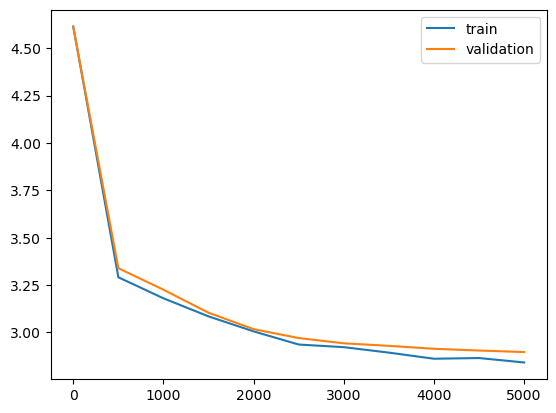

In [83]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(train_loss)*500,500), train_loss, label='train')
plt.plot(range(0,len(train_loss)*500,500), validation_loss, label='validation')
plt.legend()
plt.show

In [84]:
# Generate from the model and save it to wave_net.txt.
# We generate a maximum of 1000 tokens. 
# We feed in a batch of dimenson (1, context_size).
# The loss should get to ~ 2.0 on train and validation.
# Unfortunately, this will likely not make much sense, the capacity of this model is not ideal for this task.
# The name generation task fro HW 1 might be aother data set to use.
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
if write_to_file:
    open('wave_net.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

C:\Users\Alex\AppData\Local\Temp\ipykernel_29580\696807408.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits) # (N, vocab_size)


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
IMt siieirr, Ais iu je oe.

yTINIabug h rnetre grovhe
Se,
thfaI Toadc ruo reFmi,rtmthr me fhuthnikyac eootyie'r oome tenddam sute ui, Jabfh dsowsaia  yeos lgs  bmtu niced ffto e'rax co,euaav noss cam meauutartka, f peonnvedss ramir- a s,easwmeyssy ihe? th hhacinspsairr gece daf e An fe: rutimserH an,mi o nosftinth -hlesaat sronbl omoas chho hms.

I
'pL ICgNs shf  bi riy beatnarf ss wohP  tids wepsb g  worif worsa thea miss n: he

ThoI kilMesyobap s twweon neti chodrem-td  ln ohi,iu fef reohi r  


Bonus (+5 max - If you do this and it's all right this assignment will be 13/10.)
- Add some residual connections. Does this improve gradient zero issues?
 - Add some logging to figure out the number of zero gradients across the network before and after you add the residual connections.
- Add some plots that show the train and validation loss, per k iterations. You might want k < 500.
- Use LayerNorm instead of batch norm.
- Use the names.txt file from assignment 1. How do the names look?

### Name

In [86]:
with open('names.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [87]:
# Get all the unique characters in the text.                                                                                                             
chars = list(set(text))
vocab_size = len(list(set(text)))
# As usual, create a mapping from a character to a text.                                                                                                                            
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x:[stoi[e] for e in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode = lambda x:''.join(itos[e] for e in x)

data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n:]

In [88]:
model = WaveNetMLPLanguageModel_layernorm().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()) , 'M parameters')

# Create a PyTorch optimizer. Use AdamW.                                                                                                                                                                                                                                        
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

22221 M parameters


In [89]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
train_loss = []
validation_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        validation_loss.append(losses['val'])
        print('Number of zero gradient parameters: ', sum(p.grad is None for p in model.parameters()))
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')

    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    optimizer.step()

Number of zero gradient parameters:  5
step 0: train loss 3.7160, val loss 3.7075
Number of zero gradient parameters:  0
step 500: train loss 2.7494, val loss 2.8597
Number of zero gradient parameters:  0
step 1000: train loss 2.6576, val loss 2.7701
Number of zero gradient parameters:  0
step 1500: train loss 2.6117, val loss 2.7346
Number of zero gradient parameters:  0
step 2000: train loss 2.5560, val loss 2.6908
Number of zero gradient parameters:  0
step 2500: train loss 2.5500, val loss 2.6729
Number of zero gradient parameters:  0
step 3000: train loss 2.5309, val loss 2.6411
Number of zero gradient parameters:  0
step 3500: train loss 2.5133, val loss 2.6251
Number of zero gradient parameters:  0
step 4000: train loss 2.5042, val loss 2.6278
Number of zero gradient parameters:  0
step 4500: train loss 2.5028, val loss 2.6335
Number of zero gradient parameters:  0
step 4999: train loss 2.4957, val loss 2.5982


<function matplotlib.pyplot.show(close=None, block=None)>

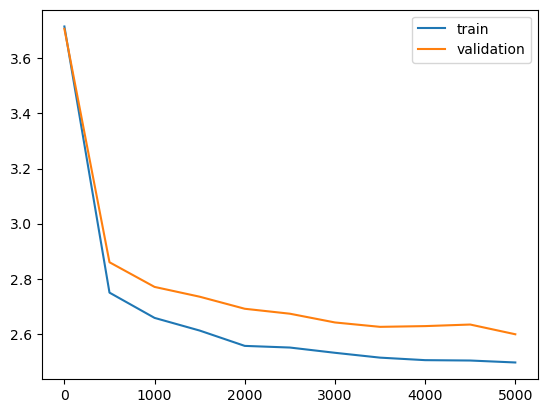

In [90]:
plt.plot(range(0,len(train_loss)*500,500), train_loss, label='train')
plt.plot(range(0,len(train_loss)*500,500), validation_loss, label='validation')
plt.legend()
plt.show

In [91]:
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


C:\Users\Alex\AppData\Local\Temp\ipykernel_29580\696807408.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits) # (N, vocab_size)


emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
nileabab
yaalinawee
kidhyleidyre
maeaal
riwhasnia
kmazienmeavolvabelana
brisanve
oaatga
bkiviyc
eloa
riiar
bsnhlana
eiasy
retell
lnoo
mralyeaagidhae
eenn
arnhet
mmsia
lh
hualtby
atiae
kaaatrlzacelh
ccia
tiykas
aeninn
coklelmoye
oinaenan
bhyi
xatvih
raiil
jhyzaya
zeecxai
ehmarlhe
masaytt
heblalocuyk
itzayn
amaaea
dinannhn
vilaw
nn
tlineana
oyneh
jiholanwnia
iarn
ceaas
lhw
iidato
dhyeclenene
saiato
nrhel
nyrih
aaami

nirdanrs
amahselloeevan
aanc
lyayenna
sar
yri
ramiaawor
niil

selgn
cnnia
ealytanv
